# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")


## test the LightGlue class  dd

fatal: destination path 'LightGlue' already exists and is not an empty directory.
/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/stereo_matching_lightglue/LightGlue


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [3]:
!pip install ultralytics
from IPython import display
display.clear_output()

from ultralytics import YOLO

In [26]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [65]:
#/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/extract_attack_clips.ipynb
video_path = "/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/LoomExp2022/short_videos/15_cam12_stacked_short_20_240.mp4"
video_path = "/Volumes/Elements/attacks/andrew/12_12_2023_S6_L1_01_500.MP4"
# read video
import cv2
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"fps: {fps}, n_frames: {n_frames}, frame_width: {frame_width}, frame_height: {frame_height}")

# read first frame
#ret, frame = cap.read()
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# read frame at frame 100
cap.set(cv2.CAP_PROP_POS_FRAMES, 9*120+35)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#split frame in half (left and right)
frame_left = frame[:, :frame_width//2]
frame_right = frame[:, frame_width//2:]

cv2.imwrite("frame_left.png", cv2.cvtColor(frame_left, cv2.COLOR_RGB2BGR))
cv2.imwrite("frame_right.png", cv2.cvtColor(frame_right, cv2.COLOR_RGB2BGR))

fps: 119.88011988011988, n_frames: 2039, frame_width: 3840, frame_height: 1080


True

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

In [75]:
#model = YOLO('/content/drive/My Drive/Projects/LoomExp2022/best_chromis_far.pt')
model = YOLO('/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com//My Drive/best_close_chromis.pt')


image1_path = "/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/Bommie_feeding/3D_tracking_vscode/left/1000.png"
image2_path = "/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/Bommie_feeding/3D_tracking_vscode/right/1000.png"

# load video 
video1_path = "/Volumes/HD_Feeding/30_11_2023/S1_L1/Card_1_left/DCIM/100GOPRO/GX030035.MP4"
video2_path = "/Volumes/HD_Feeding/30_11_2023/S1_L1/Card_2_right/DCIM/100GOPRO/GX030455.MP4"


cap1 = cv2.VideoCapture(video1_path)
cap1.set(cv2.CAP_PROP_POS_FRAMES, 61)
results_left =[]

left_tracks =[]
for i in range(4):
    ret, frame = cap1.read()
    results_left = model.track(source = frame, persist=True)

    if results_left[0].boxes is not None:
        for box in results_left[0].boxes.data:
            x1, y1, x2, y2 , id, conf, xxx = box.detach().cpu().numpy()
            frame_number = i
            #convert to numeric and append to left_tracks and frame if
            left_tracks.append([id, frame_number, x1, y1, x2, y2])

right_tracks =[]
cap2 = cv2.VideoCapture(video2_path)
cap2.set(cv2.CAP_PROP_POS_FRAMES, 0)
for i in range(4):
    ret, frame = cap2.read()
    results_right = model.track(source = frame, persist=True)

    if results_right[0].boxes is not None:
        for box in results_right[0].boxes.data:
            x1, y1, x2, y2 , id, conf, xxx = box.detach().cpu().numpy()
            frame_number = i
            #ppend to left_tracks and frame if
            right_tracks.append([id, frame_number, x1, y1, x2, y2])

results_left = model.predict(source = image1_path)
results_right = model.predict(source = image2_path)



0: 1088x1920 6 chromiss, 1880.9ms
Speed: 24.7ms preprocess, 1880.9ms inference, 3.0ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1695.7ms
Speed: 12.9ms preprocess, 1695.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1722.3ms
Speed: 13.6ms preprocess, 1722.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 6 chromiss, 1737.1ms
Speed: 12.9ms preprocess, 1737.1ms inference, 4.0ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 chromis, 1708.0ms
Speed: 12.2ms preprocess, 1708.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 7 chromiss, 1713.0ms
Speed: 15.3ms preprocess, 1713.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 7 chromiss, 1663.2ms
Speed: 15.9ms preprocess, 1663.2ms inference, 5.8ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 7 chromiss, 1720.3ms
Speed: 

In [74]:
left_tracks

[[1.0, 0, 2186.3105, 400.16974, 2273.3433, 449.7989],
 [2.0, 0, 2940.0635, 247.85468, 3025.211, 290.78717],
 [3.0, 0, 3717.145, 1106.8711, 3839.4165, 1193.3516],
 [4.0, 0, 2111.7688, 631.4764, 2148.364, 678.5588],
 [5.0, 0, 1993.6481, 694.3804, 2029.0331, 738.16016],
 [6.0, 0, 2992.9946, 255.84122, 3022.4243, 321.13223],
 [1.0, 1, 2182.9277, 399.99112, 2269.013, 451.14108],
 [2.0, 1, 2936.1433, 247.51854, 3022.5027, 291.57632],
 [3.0, 1, 3724.4648, 1111.055, 3839.403, 1200.2609],
 [4.0, 1, 2113.8484, 631.2217, 2151.0784, 677.9565],
 [5.0, 1, 1993.6552, 693.0369, 2027.873, 735.93695],
 [6.0, 1, 2994.8706, 255.07726, 3022.7556, 323.94092],
 [1.0, 2, 2180.4739, 400.31003, 2262.3845, 452.1779],
 [2.0, 2, 2933.2441, 247.78185, 3018.3892, 292.8151],
 [3.0, 2, 3734.2874, 1115.0216, 3839.7358, 1200.2023],
 [4.0, 2, 2115.1853, 630.19727, 2154.6616, 677.1924],
 [5.0, 2, 1993.4016, 691.7768, 2027.7406, 734.5796],
 [6.0, 2, 2996.8284, 259.0748, 3023.2908, 326.8576],
 [1.0, 3, 2176.826, 400.39792, 

In [67]:
results_left[0].boxes.data

tensor([[2.1768e+03, 4.0040e+02, 2.2572e+03, 4.5353e+02, 1.0000e+00, 8.9723e-01, 0.0000e+00],
        [2.9282e+03, 2.4842e+02, 3.0151e+03, 2.9392e+02, 2.0000e+00, 8.7463e-01, 0.0000e+00],
        [3.7414e+03, 1.1159e+03, 3.8399e+03, 1.2031e+03, 3.0000e+00, 8.0152e-01, 0.0000e+00],
        [2.1167e+03, 6.2847e+02, 2.1565e+03, 6.7698e+02, 4.0000e+00, 7.2967e-01, 0.0000e+00],
        [1.9930e+03, 6.9059e+02, 2.0273e+03, 7.3378e+02, 5.0000e+00, 7.7120e-01, 0.0000e+00],
        [2.9977e+03, 2.6883e+02, 3.0248e+03, 3.2980e+02, 6.0000e+00, 7.2741e-01, 0.0000e+00]])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


image 1/1 /Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/Bommie_feeding/3D_tracking_vscode/left/24000.png: 1088x1920 7 chromiss, 1915.7ms
Speed: 23.6ms preprocess, 1915.7ms inference, 2.8ms postprocess per image at shape (1, 3, 1088, 1920)

image 1/1 /Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/Bommie_feeding/3D_tracking_vscode/right/24000.png: 1088x1920 8 chromiss, 1715.7ms
Speed: 12.7ms preprocess, 1715.7ms inference, 4.0ms postprocess per image at shape (1, 3, 1088, 1920)


tensor([], dtype=torch.int64)


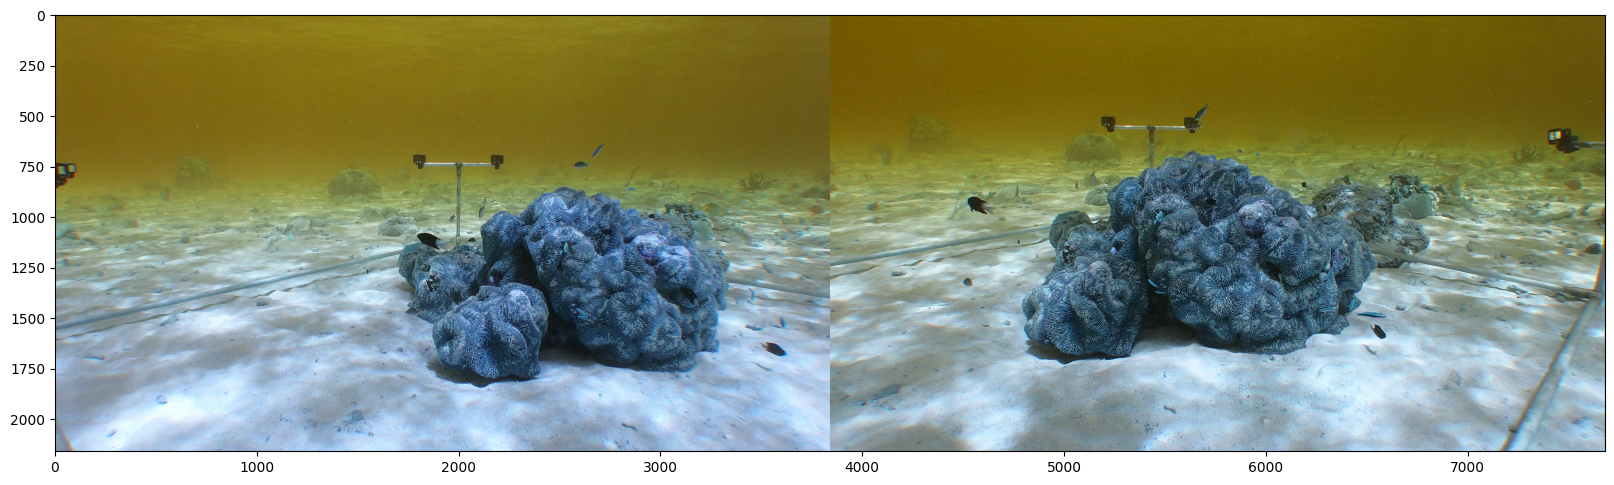

In [42]:
#model = YOLO('/content/drive/My Drive/Projects/LoomExp2022/best_chromis_far.pt')
model = YOLO('/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com//My Drive/best_close_chromis.pt')


image1_path = "/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/Bommie_feeding/3D_tracking_vscode/left/24000.png"
image2_path = "/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/Bommie_feeding/3D_tracking_vscode/right/24000.png"
results_left = model.predict(source = image1_path)
results_right = model.predict(source = image2_path)

image0 = load_image(image1_path) # load_image("/content/drive/MyDrive/Projects/chromis/Bommie_feeding/Deployments/17_11_2023/Calib_images/camera_0_frame_327.jpg")
image1 = load_image(image2_path) # load_image("/content/drive/MyDrive/Projects/chromis/Bommie_feeding/Deployments/17_11_2023/Calib_images/camera_1_frame_327.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]


#get matches01 within a bounding box in the left image
#bounding box
l_x1 = results_left[0].boxes.data[:,0]
l_y1 = results_left[0].boxes.data[:,1]
l_x2 = results_left[0].boxes.data[:,2]
l_y2 = results_left[0].boxes.data[:,3]
#print(l_x, l_y, r_x, r_y)


r_x1 = results_right[0].boxes.data[:,0]
r_y1 = results_right[0].boxes.data[:,1]
r_x2 = results_right[0].boxes.data[:,2]
r_y2 = results_right[0].boxes.data[:,3]
#check which matches are within any of the bounding boxs in l_x, l_y,r_x,r_y each row represents diff bb (kpts0 is a tensor with shape (n_matches, 2))
matches_in_box_left = []
matches_in_box_left_index =[]
for i in range(len(l_x1)):
    x = l_x1[i]
    y = l_y1[i]
    w = l_x2[i] - l_x1[i]
    h = l_y2[i] - l_y1[i]
    j = 0
    for match in m_kpts0:
        if x < match[0] < x+w and y < match[1] < y+h:
            matches_in_box_left.append(match)
            matches_in_box_left_index.append(j)
        j = j + 1

matches_in_box_right = []
matches_in_box_right_index = []
for i in range(len(r_x1)):
    x = r_x1[i]
    y = r_y1[i]
    w = r_x2[i] - r_x1[i]
    h = r_y2[i] - r_y1[i]
    j = 0

    for match in m_kpts1:
        if x < match[0] < x+w and y < match[1] < y+h:
            matches_in_box_right.append(match)
            matches_in_box_right_index.append(j)
        j = j + 1    


# find the rows shared between matches_in_box_left and matches_in_box_right
shared_rows = []
for i in matches_in_box_left_index:
    if i in matches_in_box_right_index:
        shared_rows.append(i)

#plot matches_in_box_left matches_in_box_right in bounding box on the left and right imagea with opencv stack images horizontally
image0 = cv2.imread(image1_path)
image1 = cv2.imread(image2_path)

matches_left = matches[shared_rows][:,0]
matches_right = matches[shared_rows][:,1]

print(matches_left)
p_left = kpts0[matches_left]
p_right = kpts1[matches_right]

n = len(p_left)
colors = 255 * np.random.rand(n,3)
plt.figure(figsize=(20, 10))
i = 0
for match in p_left:
    cv2.circle(image0, (int(match[0]), int(match[1])), 5,  colors[i], -1)
    i = i + 1
i = 0
for match in p_right:
    cv2.circle(image1, (int(match[0]), int(match[1])), 5,  colors[i], -1)
    i = i + 1
plt.imshow(np.hstack([image0, image1]))


In [41]:
print(matches_left)

tensor([ 504,  511, 1093])


In [27]:
print(colors)

[[     30.172      103.61      222.47]
 [     232.84      5.0888      143.91]
 [     194.37      29.204      205.39]
 [      171.9      195.14      207.26]
 [     35.454      6.7667      67.139]
 [     253.66      112.57         237]
 [      121.8      64.582      146.78]
 [     144.68      228.32      110.47]
 [     32.812       105.8      169.82]
 [     64.982     0.68857       210.7]
 [     80.462      93.014      105.96]
 [     223.85       14.92      220.88]
 [     103.15      46.415      205.37]
 [     114.04      136.19      179.04]
 [     250.63      69.725      138.91]]


In [80]:
video_path = "/Volumes/Elements/attacks/andrew/13_11_2023_S1_L2_05_675.MP4"

#for loop to go through all frames in video and save out a video of the matches
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"fps: {fps}, n_frames: {n_frames}, frame_width: {frame_width}, frame_height: {frame_height}")

# frames = 1:n_frames bt 120
frames = np.arange(0, n_frames, 3)
for fr in frames:
    # read first frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, fr)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    #split frame in half (left and right)
    frame_left = frame[:, :frame_width//2]
    frame_right = frame[:, frame_width//2:]

    cv2.imwrite("frame_left.png", cv2.cvtColor(frame_left, cv2.COLOR_RGB2BGR))
    cv2.imwrite("frame_right.png", cv2.cvtColor(frame_right, cv2.COLOR_RGB2BGR))



    image0 = load_image("frame_left.png") # load_image("/content/drive/MyDrive/Projects/chromis/Bommie_feeding/Deployments/17_11_2023/Calib_images/camera_0_frame_327.jpg")
    image1 = load_image("frame_right.png") # load_image("/content/drive/MyDrive/Projects/chromis/Bommie_feeding/Deployments/17_11_2023/Calib_images/camera_1_frame_327.jpg")

    results_left = model.predict(source = "frame_left.png")
    results_right = model.predict(source = "frame_right.png")


    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]


    #get matches01 within a bounding box in the left image
    #bounding box
    l_x1 = results_left[0].boxes.data[:,0]
    l_y1 = results_left[0].boxes.data[:,1]
    l_x2 = results_left[0].boxes.data[:,2]
    l_y2 = results_left[0].boxes.data[:,3]
    #print(l_x, l_y, r_x, r_y)


    r_x1 = results_right[0].boxes.data[:,0]
    r_y1 = results_right[0].boxes.data[:,1]
    r_x2 = results_right[0].boxes.data[:,2]
    r_y2 = results_right[0].boxes.data[:,3]
    #check which matches are within any of the bounding boxs in l_x, l_y,r_x,r_y each row represents diff bb (kpts0 is a tensor with shape (n_matches, 2))
    matches_in_box_left = []
    matches_in_box_left_index =[]
    for i in range(len(l_x1)):
        x = l_x1[i]
        y = l_y1[i]
        w = l_x2[i] - l_x1[i]
        h = l_y2[i] - l_y1[i]
        j = 0
        for match in m_kpts0:
            if x < match[0] < x+w and y < match[1] < y+h:
                matches_in_box_left.append(match)
                matches_in_box_left_index.append(j)
            j = j + 1

    matches_in_box_right = []
    matches_in_box_right_index = []
    for i in range(len(r_x1)):
        x = r_x1[i]
        y = r_y1[i]
        w = r_x2[i] - r_x1[i]
        h = r_y2[i] - r_y1[i]
        j = 0

        for match in m_kpts1:
            if x < match[0] < x+w and y < match[1] < y+h:
                matches_in_box_right.append(match)
                matches_in_box_right_index.append(j)
            j = j + 1    


    # find the rows shared between matches_in_box_left and matches_in_box_right
    shared_rows = []
    for i in matches_in_box_left_index:
        if i in matches_in_box_right_index:
            shared_rows.append(i)

    #plot matches_in_box_left matches_in_box_right in bounding box on the left and right imagea with opencv stack images horizontally
    image0 = cv2.imread("frame_left.png")
    image1 = cv2.imread("frame_right.png")

    matches_left = matches[shared_rows][:,0]
    matches_right = matches[shared_rows][:,1]

    p_left = kpts0[matches_left]
    p_right = kpts1[matches_right]

    n = len(p_left)
    colors = plt.cm.viridis(np.linspace(0, 1, n))

    plt.figure(figsize=(20, 10))
    i = 0
    for match in p_left:
        #plot each match as a circle with a unique color
        cv2.circle(image0, (int(match[0]), int(match[1])), 5,  colors[i], -1)
        
        i = i + 1
    i = 0
    for match in p_right:
        cv2.circle(image1, (int(match[0]), int(match[1])), 5,  colors[i], -1)
        i = i + 1
    plt.imshow(np.hstack([image0, image1]))

    #save out plot as image with frame number in name
    plt.savefig(f"matches_{fr}.png")

In [ ]:
matches[matches_in_box_left_index]

tensor([[  23,  106],
        [ 278,  197],
        [ 151,   11],
        [  36, 1970],
        [  77,   49],
        [  22,  112],
        [ 142,  622]], device='cuda:0')

In [ ]:
matches[matches_in_box_right_index]

tensor([[  23,  106],
        [  22,  112],
        [ 456, 1314],
        [ 278,  197],
        [  36, 1970],
        [  77,   49],
        [ 108,   12],
        [1688,    5],
        [  25,  373],
        [ 151,   11],
        [  72,   46]], device='cuda:0')

In [ ]:
matches = matches01['matches']

np_arr = matches.detach().cpu().numpy()
print(np_arr)

[[   0  563]
 [   1  109]
 [   2  148]
 ...
 [2039 1151]
 [2041 1611]
 [2042 1340]]


In [ ]:
print(results_right[0].boxes.data[:,0])

tensor([ 771.9641,  946.4487, 1117.7925,  961.2604, 1532.7261,  942.2261,  681.7698, 1058.0422], device='cuda:0')


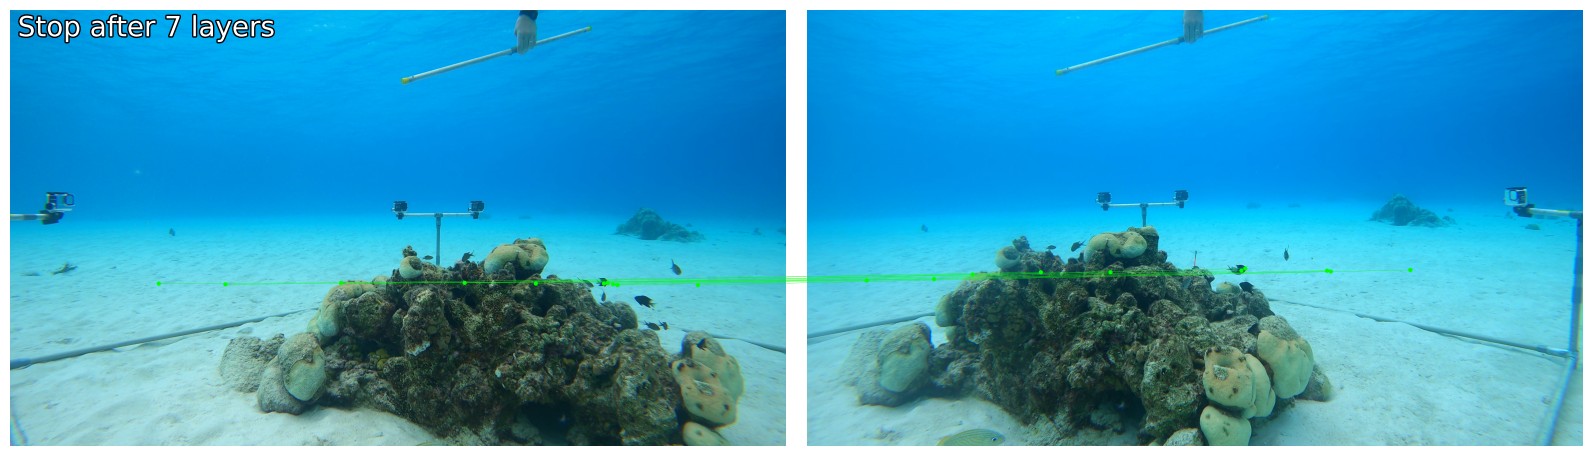

In [ ]:
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0[200:210], m_kpts1[200:210], color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

In [ ]:
print(matches[3])

tensor([14, 10])


## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

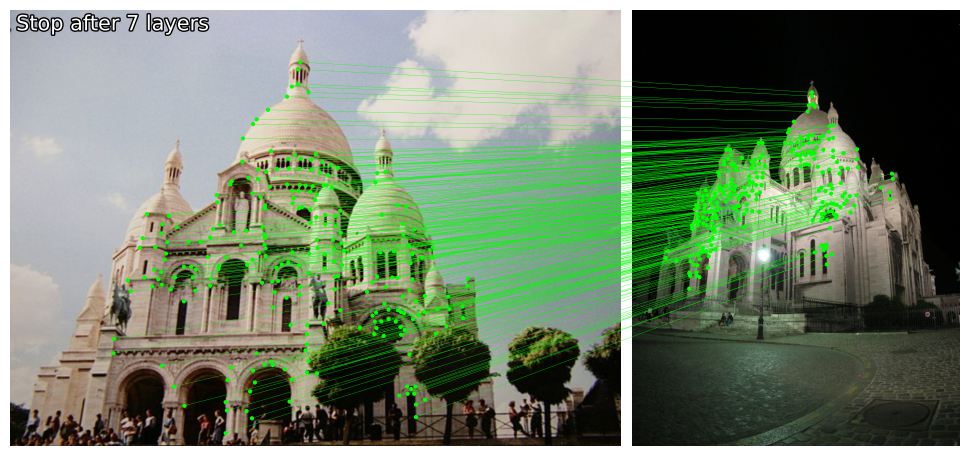

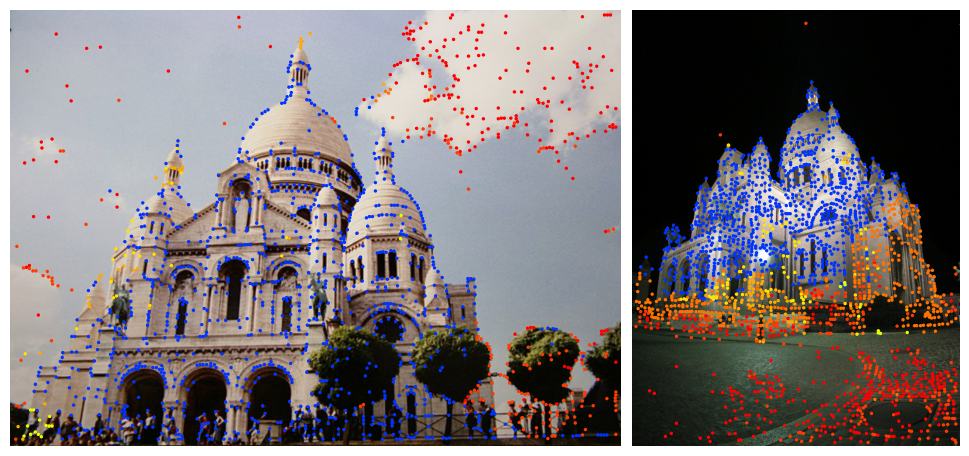

In [ ]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)